# Criação de relações

Aqui nessa etapa Gold, o resultado vai ser a tabela que vai ser a base para todo o experimento. Então aqui que os processos de *encoding* vão ocorrer, para tornar todos os dados o mais amigáveis possíveis ao modelo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set_theme(style="whitegrid")

df = pd.read_parquet('../data/silver/salaries_cleaned.parquet')

## Análise Exploratória (EDA)

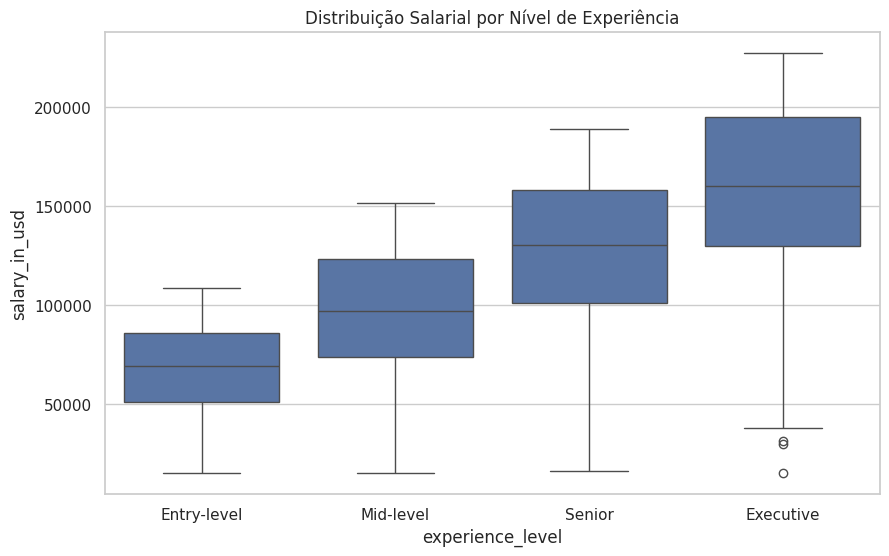

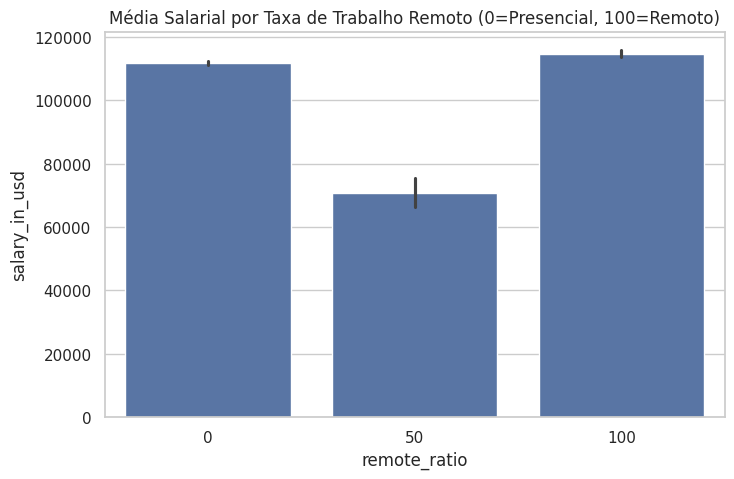

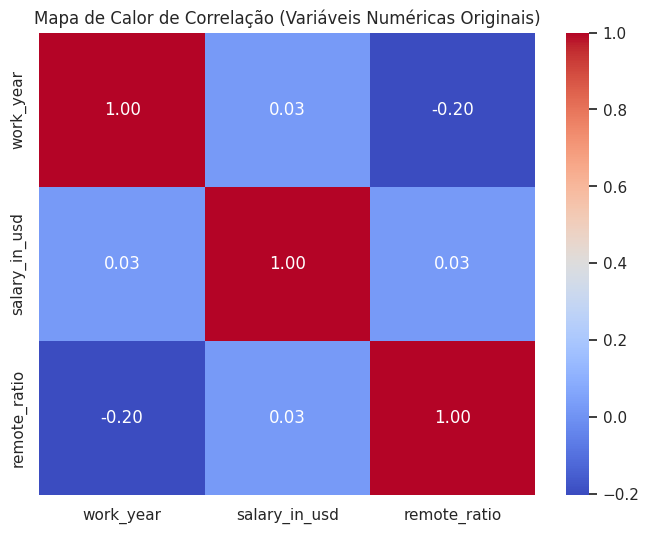

In [2]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='experience_level', y='salary_in_usd', order=['Entry-level', 'Mid-level', 'Senior', 'Executive'])
plt.title('Distribuição Salarial por Nível de Experiência')
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='remote_ratio', y='salary_in_usd', estimator='mean')
plt.title('Média Salarial por Taxa de Trabalho Remoto (0=Presencial, 100=Remoto)')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de Correlação (Variáveis Numéricas Originais)')
plt.show()

Acima o objetivo foi responder algumas dúvidas principais que surgiram, com base nessa nova análise. Por exemplo, "Sêniores realmente ganham mais nesse contexto?", para já tirar da frente essa identificação de padroões óbvios que possam viciar o modelo em algum ponto.

Outro ponto interessante é também detectar desbalanceamento, pois um problema nesse *dataset* é uma ausência ponderada de dados sobre totalmente remotos ou também freelancers. Cenários que possuem muito relevância nos dias atuais, e que pode ser um ponto fraco se o modelo não estiver preparado.

E, no último gráfico, por exemplo, buscar justificar as variáveis que mais fariam sentido para análise, visto sua correlação dos valores e importância nesses valores. Por exemplo, podem ser citados as colunas de `experience_level` e `remote_ratio`, a primeira por se mostrar muito relevante pela sua tendência clara de valores e a segunda por apresentar médias que podem fazer sentido posteriormente.

## Preparação para modelagem

Abaixo ocorrem diversos processos relevantes a essa formatação final para a versão final da base de dados.

In [3]:
mapa_experiencia = {'Entry-level': 1, 'Mid-level': 2, 'Senior': 3, 'Executive': 4}
mapa_tamanho = {'Small': 1, 'Medium': 2, 'Large': 3}

df['experience_level_encoded'] = df['experience_level'].map(mapa_experiencia)
df['company_size_encoded'] = df['company_size'].map(mapa_tamanho)

O script começou então com a ordenação de relevância dos *encodings*, para deixar claro ao modelo o que cada uma das *labels* simbolina em termos numéricos, para que haja comparação.

In [4]:
df['is_US'] = df['company_location'].apply(lambda x: 1 if x == 'US' else 0)

Após isso, já ocorreu a seleção de features para o *one-hot encoding*, sendo a company_location, unificando os valores, para evitar a criação de diversas colunas, uma para cada localização. Já que o dólar está sendo usado como base para essa análise de valores, o modelo final vai considerar apenas se aquele indivíduo é ou não dos Estados Unidos (no caso, vive lá ou não).

In [5]:
df_encoded = pd.get_dummies(df, columns=['employment_type'], prefix='job_type')

Então ele aplica o processamento do `get_dummies` no coluna de `employment_type` para que a distinção de categorias possa ocorrer de forma bem clara conforme o tipo de trabalho que a pessoa exerça. Visto que anteriormente essa coluna se mostrou com um índice interessante para análise.

In [6]:
features_finais = [
    'experience_level_encoded',
    'company_size_encoded',
    'remote_ratio',
    'is_US',
    'job_type_Full-time',
    'job_type_Contract',
    'job_type_Part-time'
]

cols_presentes = [c for c in features_finais if c in df_encoded.columns]

X = df_encoded[cols_presentes]
y = df_encoded['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamanho do Treino: {X_train.shape}")
print(f"Tamanho do Teste: {X_test.shape}")

display(X_train.head())

Tamanho do Treino: (18231, 7)
Tamanho do Teste: (4558, 7)


,experience_level_encoded,company_size_encoded,remote_ratio,is_US,job_type_Full-time,job_type_Contract,job_type_Part-time
6682,2,2,100,0,True,False,False
6181,2,2,0,1,True,False,False
4902,2,3,50,0,True,False,False
3672,2,2,0,1,True,False,False
3721,2,2,100,1,True,False,False


E então, aqui já pode ser realizado o `split` da base de dados, preparando totalmente para o que virá na próxima, que é a preparação do modelo de fato.

In [7]:
df_gold_full = pd.concat([X, y], axis=1)

df_gold_full.to_parquet('../data/gold/salaries_full.parquet', index=False)

train_dataset = pd.concat([X_train, y_train], axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)

train_dataset.to_parquet('../data/gold/salaries_train.parquet', index=False)
test_dataset.to_parquet('../data/gold/salaries_test.parquet', index=False)

print("Arquivos salvos na camada Gold:")
print("1. salaries_full.parquet (Dataset Completo)")
print("2. salaries_train.parquet (Base de Treino)")
print("3. salaries_test.parquet (Base de Teste)")

Arquivos salvos na camada Gold:
1. salaries_full.parquet (Dataset Completo)
2. salaries_train.parquet (Base de Treino)
3. salaries_test.parquet (Base de Teste)
